In [1]:
# !pip install -q --upgrade scipy
import cv2
import numpy as np
import scipy
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import albumentations as A
import glob
import os
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from tqdm import tqdm
from dataset_cityscapes import *


print(scipy.__version__)

/home/jamada/jupyterlab/eo-xai/xai_fyp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.10.1


In [2]:
import torch
import argparse
import os
import cv2

from segmentation_models_pytorch import Unet

from skimage.io import imread,imsave
import numpy as np
import rasterio as rio

import geopandas as gpd
import matplotlib.pyplot as plt
import imageio

from utils import *
from color_map import cm_data
from rasterio.features import shapes
from tqdm.notebook import tqdm

In [3]:
# %cd /home/jamada/jupyterlab/eo-xai/sobol_indices/Sobol-Attribution-Method
# !pwd


/home/jamada/jupyterlab/eo-xai/sobol_indices/Sobol-Attribution-Method
/home/jamada/jupyterlab/eo-xai/sobol_indices/Sobol-Attribution-Method


In [4]:
### getting multiple input images
import albumentations as A
import cv2
from glob import glob
import os
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from dataset_cityscapes import *
import neptune
import pickle
from segmentation_models_pytorch import Unet
import torch
import argparse
import os
import cv2
from segmentation_models_pytorch import Unet
from skimage.io import imread,imsave
import numpy as np
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import imageio

from utils import *
# from color_map import cm_data
from rasterio.features import shapes
from tqdm.notebook import tqdm

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype("float32")

import torch
# image_indexx = [2]
# print(image_indexx)
S_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "CPU")

transform_full = A.Compose([
    A.Lambda(name = "to_tensor", image = to_tensor),
])

# setup datasets
dataset_test = DataLoaderSegmentation(
    image_path = "/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/A",
    mask_path = "/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/OUT",
    transform = transform_full,
    device = S_DEVICE
)


length of images:  4736
length of masks:  4736


In [5]:
MODEL_PATH = '/home/jamada/UrbanModels/weights_pytorch/tu-tf_efficientnet_b0_Unet_whu_3-classes_40-epochs_TRY001'
THRESH = 0.5
ALPHA = 0.85
SCALE = None

#load your model with pre-trained weights
model = Unet(
        encoder_name = "tu-tf_efficientnet_b0",
        encoder_depth= 5,
        encoder_weights = None,
        decoder_use_batchnorm = True,
        decoder_channels = (256, 128, 64, 32, 16),
        decoder_attention_type = None,
        in_channels= 3,
        classes = 3,
        activation = 'sigmoid',
        aux_params = None,
    )

model = load_model(model,MODEL_PATH)
model.cuda()

Unet(
  (encoder): TimmUniversalEncoder(
    (model): EfficientNetFeatures(
      (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid(

In [6]:
image_indexx = torch.arange(10)

idxs=image_indexx
images_list=[]
masks_list=[]
for i,idx in enumerate(idxs):
    print("Testing Image: ", i)
    
    Img,tar,p_image,p_target = dataset_test.__getitem__(idx) # im,mask_gt
    if p_image.endswith('.png'):
        print(p_image)
        image = cv2.imread(p_image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        target = cv2.imread(p_target, cv2.IMREAD_UNCHANGED)
        nan_condition = np.count_nonzero(target)
        if nan_condition != 0:
        # if 1:
            # number_testing_images = number_testing_images + 1
            # add weather augmentation
            image_weather = image
            # target_weather = target
            # with torch.inference_mode():
            model_input = transform_full(image = image_weather)["image"]
            model_input = torch.from_numpy(model_input).unsqueeze(0)
            model_input -= (0.5 * 255.0)
            model_input /= (0.5 * 255.0)
            model_input = model_input.to(S_DEVICE)
            images_list.append(model_input)
            masks_list.append(target)


Testing Image:  0
/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/A/125.png
Testing Image:  1
/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/A/1048.png
Testing Image:  2
/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/A/1987.png
Testing Image:  3
/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/A/322.png
Testing Image:  4
/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/A/4051.png
Testing Image:  5
/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/A/3052.png
Testing Image:  6
/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/A/4552.png
Testing Image:  7
/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/A/3405.png
Testing Image:  8
/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/A/946.png
Testing Image:  9
/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/A/3502.png


In [7]:
print(len(images_list))
print(len(masks_list))

10
10


In [8]:
# in_dir = r'/home/jamada/jupyterlab/eo-xai/sobol_indices/Sobol-Attribution-Method-WHU/dataset/images'
# out_dir = r'/home/jamada/jupyterlab/eo-xai/sobol_indices/Sobol-Attribution-Method-WHU/results/'


# directory = os.fsencode(in_dir)

# for file in os.listdir(directory):
#     filename = os.fsdecode(file)
#     if filename.endswith(".png"):         
#         raster_file = rio.open(f'{in_dir}/{filename}')
#         full_img = raster_file.read().transpose(1,2,0)
#         full_img,rrp_info = ratio_resize_pad(full_img, ratio = None)
#         print(full_img.shape)
#         if full_img.shape[-1]==4:full_img = cv2.cvtColor(full_img,cv2.COLOR_RGBA2RGB) #WHU images are RGBA

#         full_img = normalize(full_img)
#         x = totensor(full_img)
#         print("original image:", x.shape)
#         x = x.cuda()

#         with torch.no_grad():
#             y_pred = model(x)
#             # y_pred = unpad_resize(y_pred,rrp_info)

#         mask = y_pred[0,...].cpu().numpy().transpose(1,2,0)
#         mask=mask[:,:,0]
        
        
#         #to png
#         os.makedirs(out_dir,exist_ok=True)

#         imageio.imwrite(f'{out_dir}/results_{filename}', mask)


        


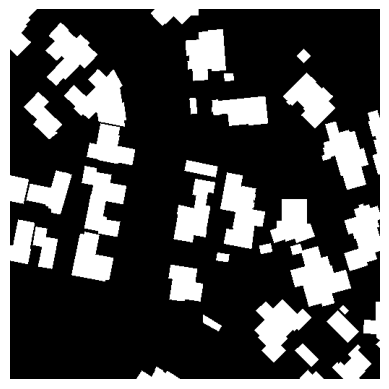

In [6]:
# # Load the building mask in grayscale mode
# image_path = '/home/jamada/jupyterlab/eo-xai/sobol_indices/Sobol-Attribution-Method-WHU/dataset/gt_mask/2_0.png' 
# mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# plt.imshow(mask, cmap='gray')
# plt.axis('off')  # To turn off axis numbers and ticks
# plt.show()

# Playing with the `grid_size` parameter

In [9]:
from sobol_attribution_method.torch_explainer import SobolAttributionMethod

In [10]:
def show(img, **kwargs):
  if torch.is_tensor(img):
    img = img.detach().cpu().numpy()
    img = np.moveaxis(img, 0, -1)

  img -= img.min(); img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

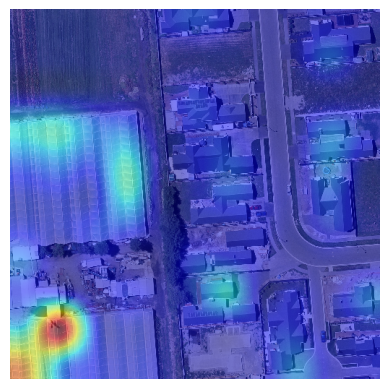

(512, 512)


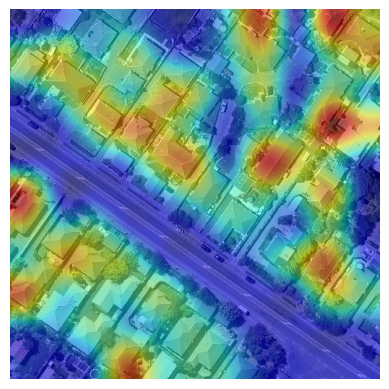

(512, 512)


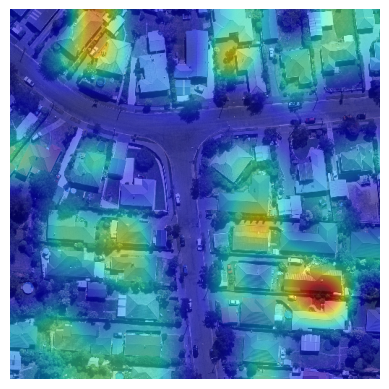

(512, 512)


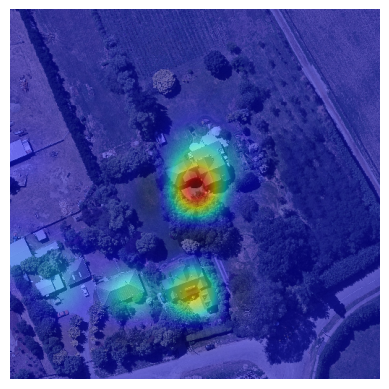

(512, 512)


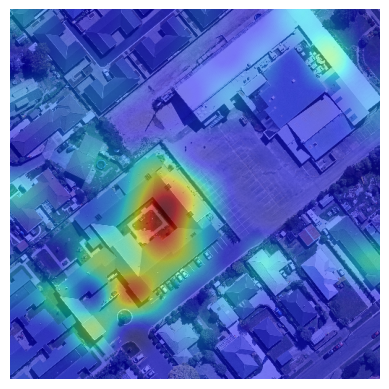

(512, 512)


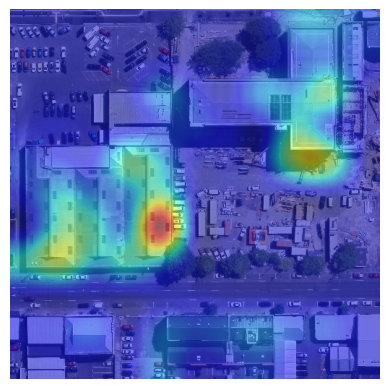

(512, 512)


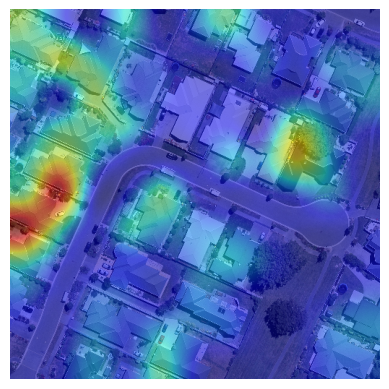

(512, 512)


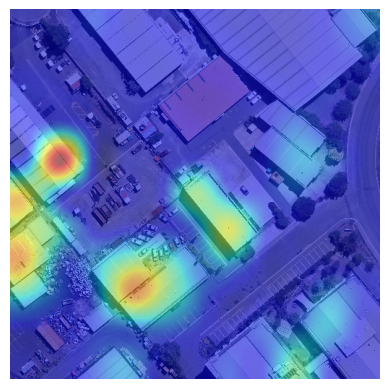

(512, 512)


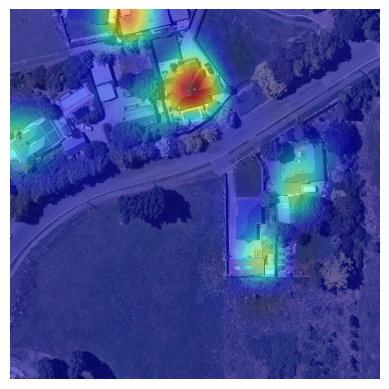

(512, 512)


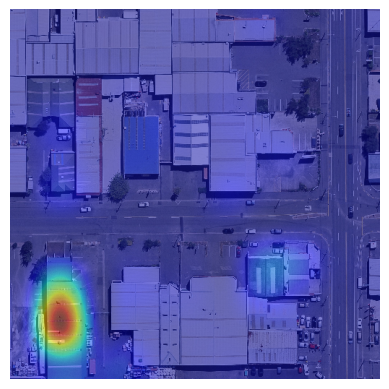

(512, 512)


In [11]:
sobol_saliency_list=[]
for j in range(10):

    explainer = SobolAttributionMethod(model,masks_list[j], grid_size=11, nb_design=32, batch_size=8)
    # print(x.shape)
    # print(len(images_list[j]))
    explanations = explainer(images_list[j])
    
    # print(y)
    
    for i in range(len(images_list[j])):
      plt.subplot(1, len(images_list[j]), i+1)
      show(images_list[j][i].cpu())
      show(explanations[i], cmap='jet', alpha=0.5)
      plt.show()
      print(explanations[i].shape)
      sobol_saliency_list.append(explanations[i])

In [16]:
print(explanations[0].shape,explanations[0].min(), explanations[0].max())

(512, 512) 0.0 1.0


In [15]:
print(len(images_list))
print(len(masks_list))
print(len(sobol_saliency_list))

10
10
10
torch.float32


In [17]:
torch.save(images_list, './list_of_images.t')


In [18]:
torch.save(masks_list, './list_of_masks.t')


In [19]:
torch.save(sobol_saliency_list, './list_of_sobol.t')
